## To load data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ibrahimsoboh","key":"b22a3e8a2d92ed73fe5a48b688bfd35a"}'}

In [ ]:
! mkdir ~/.kaggle



mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dog-breed-identification

dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip dog-breed-identification.zip -d dog-breed-identification

Archive:  dog-breed-identification.zip
replace dog-breed-identification/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Create a notebook containing the following analysis:
- Check / adjust data quality
- Extract features from images - Orb
- Reduce dimensionality - PCA 
- Classify dogs per breeds - Normal Classifier
- Once you are done with these 4 points, use a CNN instead and compare results with your previous solution.

Submit your notebook in HTML format

# Exploratory Data Analysis 

In [5]:
import cv2
import os
import cv2
import tqdm
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
warnings.filterwarnings("ignore")                   # Suppressing Jupyter Notebook Warnings
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [6]:

# files = [file for file in glob.glob("dog_breed/train/*.jpg")]
images_train = [cv2.imread(file) for file in glob.glob("dog-breed-identification/train/*.jpg")]

images_train[0]

[]

In [ ]:
import pandas as pd
labels = pd.read_csv('dog-breed-identification/labels.csv')
labels_breed = labels['breed']
labels_breed

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [ ]:
# Saving the count of total number of unique breeds to a variabkle
unique_breeds = np.unique(labels_breed)

print("Total number of unique breeds : ", len(unique_breeds))

Total number of unique breeds :  120


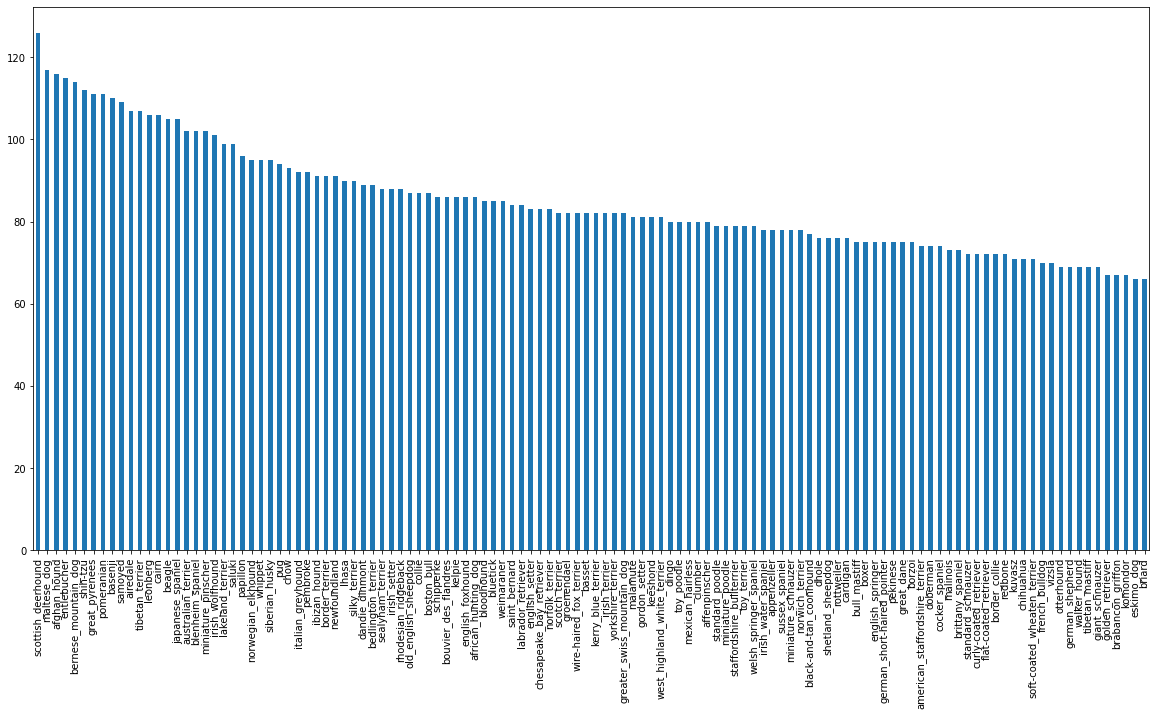

In [ ]:
labels['breed'].value_counts().plot.bar(figsize=(20, 10));

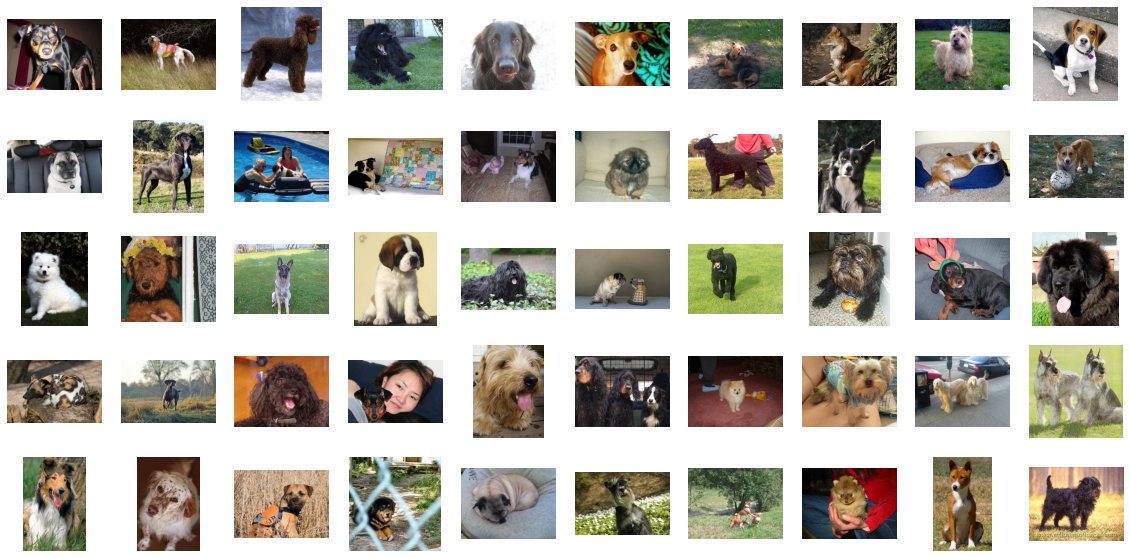

In [ ]:
import numpy as np

fig = plt.figure(figsize=(20, 10))
columns = 10
rows = 5
for i, img in zip(range(1, columns*rows +1), images_train):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

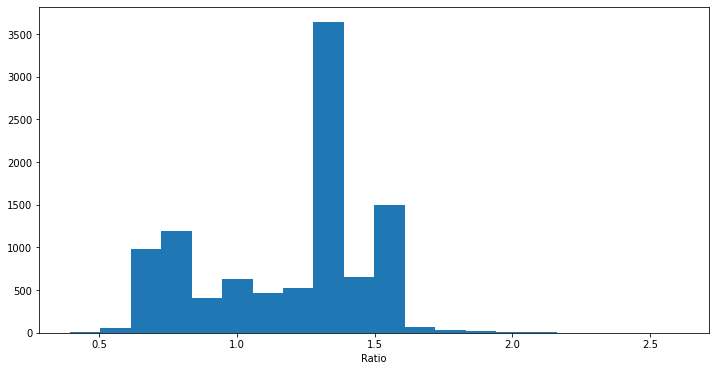

In [ ]:
ratios = []
fig = plt.figure(figsize=(12, 6))
fig.add_subplot()
for image in images_train:
  ratios.append(image.shape[1] / image.shape[0])
plt.xlabel("Ratio")
plt.hist(ratios, bins=20)
plt.show()


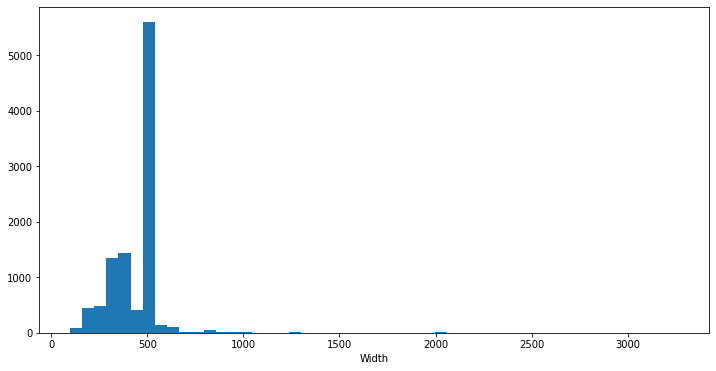

In [ ]:
widths = []
fig = plt.figure(figsize=(12, 6))
fig.add_subplot()
for image in images_train:
  widths.append(image.shape[1])
plt.xlabel("Width")
plt.hist(widths, bins=50)
plt.show()

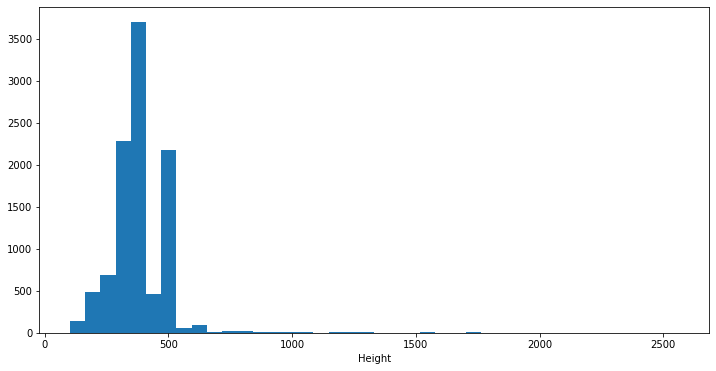

In [ ]:
heights = []
fig = plt.figure(figsize=(12, 6))
fig.add_subplot()
for image in images_train:
  heights.append(image.shape[0])
plt.xlabel("Height")
plt.hist(heights, bins=40)
plt.show()

# Data Preprocessing

In [ ]:
width = 500
height = 350

width/height
# ratio value is in agreement with our most popular ratio histogram, we will resize with these values

1.4285714285714286

In [ ]:
resize_params = (width, height)

train_resized = []

for image in images_train:
  train_resized.append(cv2.resize(image, resize_params, interpolation=cv2.INTER_LINEAR))

del images_train # save memory

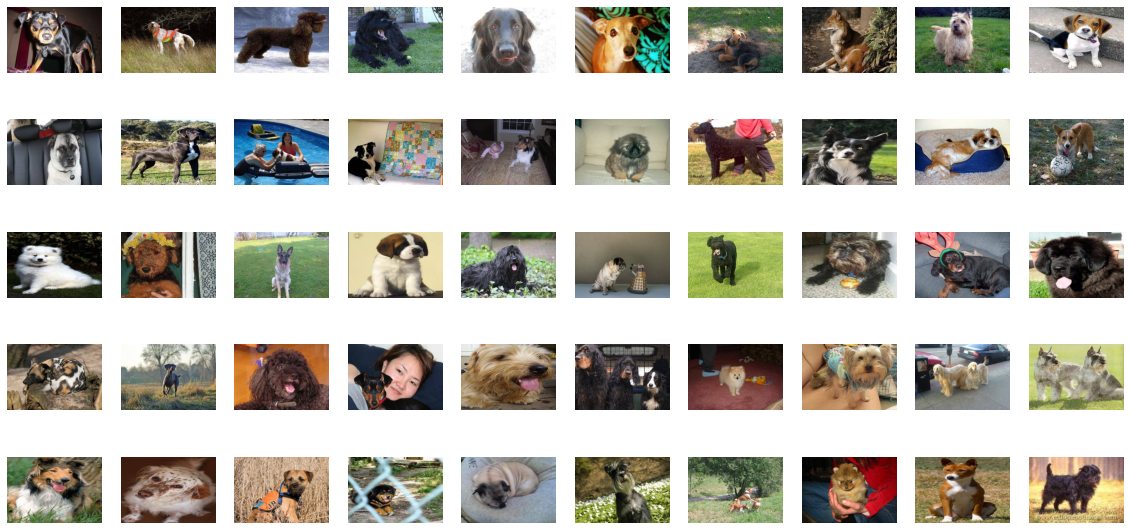

In [ ]:
import numpy as np

fig = plt.figure(figsize=(20, 10))
columns = 10
rows = 5
for i, img in zip(range(1, columns*rows +1), train_resized):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

# resized images

In [ ]:
from sklearn.model_selection import train_test_split

X = train_resized
y = labels_breed
X_train, X_test, y_train, y_test = train_test_split(train_resized, list(y),
                                                    test_size=0.2,random_state=42)

print(f"Number of training images : {len(X_train)}")
print(f"Number of testing images : {len(X_test)}")


Number of training images : 8177
Number of testing images : 2045


In [ ]:
# Setting the Image Size
IMAGE_SIZE = 224

# Creating a function to preprocess the images
def process_image(image_path):
    
    # Read in the image
    image = tf.io.read_file(image_path)
    
    # Turn the image into numerical tensors
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Convert the color channel values from 0-225 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize the image
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    
    return image


# Creating a function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [ ]:
# Setting the batch size at 32 
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Function to batch the data
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
  
    # If the data if a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        # If the data is a training dataset, we shuffle it
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                   tf.constant(y))) # labels
    
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the data into batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [ ]:
# Creating training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_test, y_test, valid_data=True)